In this notebook, the outputs generated for each scenario separately are combined for comparison of the scenarios. <br>
Plots are generated for visual comparison. Many different scenarios can be compared (i.e. more than 30).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick

In [17]:
# must be adjusted, if additional scenarios are used (compare with list in 00_launcher)
scenarios = ['base', 'ref_35', 'policy_35',
             'tax_7', 'tax_8', 'tax_9', 'tax_12',
             'prk_1', 'prk_2', 'prk_4', 'lim', 
             'pt_1', 'pt_2-4', 'pt_5', 'pt_6', 'pt_7', 'pt_9',
             'inf_1', 'inf_2', 'inf_3_run-rail', 'inf_4', 'inf_5', 'inf_6',
             'reg_1', 'reg_2', 'reg_3', 'reg_4', 'reg_5'
             ]

"\nscenarios = ['base', 'ref_35', 'policy_35',\n             'tax_7', 'tax_8', 'tax_9', 'tax_12',\n             'prk_1', 'prk_2', 'prk_4', 'lim', \n             'pt_1', 'pt_2-4', 'pt_5', 'pt_6', 'pt_7', 'pt_9',\n             'inf_1', 'inf_2', 'inf_3_run-rail', 'inf_4', 'inf_5', 'inf_6',\n             'reg_1', 'reg_2', 'reg_3', 'reg_4', 'reg_5'\n             ]\n"

In [8]:
cmap_mode = plt.get_cmap('CMRmap')
colormap = {'car':cmap_mode(.45), 'car_long':cmap_mode(.45), 'car_local':cmap_mode(.51),
            'rail':cmap_mode(.24), 'rail_short':cmap_mode(.24), 'rail_local':cmap_mode(.15), 'rail_long':cmap_mode(.3),
            'coach':cmap_mode(.85), 'bus':cmap_mode(.8), 'bus_long':cmap_mode(.8), 'bus_local':cmap_mode(.7),
            'air':cmap_mode(.02), 'walk':cmap_mode(.93)
            }

In [9]:
# define function to swap columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [10]:
# Function to modify the x-axis labels
def custom_xticklabels(x, stay_unchanged):
    # If the scenario is in stay_unchanged, return the scenario name
    # If not, add "*" at the end of the scenario name
    if x in stay_unchanged + ["sum"]:
        return x
    else:
        return f"{x}*"

## Compare passenger kilometer shares by mode type between the scenarios

In [18]:
# define output excel file to be read for every scenario (every folder in 'output')
file_name = 'results_total.xlsx'
sheet_name = 'pkm_shares_total'
output_path = '../output/'
save_path = '../output/comparison/pkm/'
unit = 'bn. pkm'
modes = ['air', 'bus', 'car', 'rail', 'walk', 'total']

if not os.path.exists(save_path):
    os.mkdirs(save_path)


def create_excl_merged(output_path, file_name, sheet_name, unit, modes, scenarios):
    # create a list with all paths to the files to be compared
    file_list = []
    for x in range(len(scenarios)):
        file_list.append(os.path.join(output_path, scenarios[x], file_name))

    # read the data for every scenario and combine it in one list
    excl_list = []
    for x in range(len(file_list)):
        excl_list.append(pd.read_excel(file_list[x], sheet_name=sheet_name))

    # convert the list to a pandas DataFrame for better handling
    excl_merged = pd.DataFrame()
    for excl_file in excl_list:
        excl_merged = pd.concat([excl_merged, excl_file], ignore_index=True)
    excl_merged['mode']=excl_merged['Unnamed: 0']
    excl_merged.drop(['Unnamed: 0'], axis=1, inplace=True)

    # add the scenario name to the data in the pandas DataFrame
    excl_merged['scenario'] = ""
    for x in range(len(scenarios)):
        # add a row for 'air' if that row is missing (= no air travel)
        if excl_merged.at[x*6, 'mode'] != 'air':
            excl_merged.loc[x*6-0.5] = [0.0, 'air', np.nan]
            excl_merged = excl_merged.sort_index().reset_index(drop=True)
        # write the name in the scenario to all 
        for y in range(0, len(modes)):
            excl_merged.at[y+x*6, 'scenario'] = scenarios[x]

    excl_merged = swap_columns(excl_merged, unit, 'scenario')
    
    return excl_merged

excl_merged = create_excl_merged(output_path, file_name, sheet_name, unit, modes, scenarios)

In [12]:
# plot the data, for every mode type their own plot with values for all scenarios in it
def plot_pkm(excl_merged, diff_ref=False):
    for mode in modes:
        pkm_mode = excl_merged.drop(excl_merged[excl_merged['mode'] != mode].index)
        fig = plt.figure(figsize=(10,5))
        
        # create bar chart   
        if diff_ref:
            # exclude base scenario
            pkm_mode = pkm_mode[1:]
            ref_35_row = pkm_mode[pkm_mode['scenario'] == 'ref_35'].iloc[0]
            pkm_mode['pkm_diff'] = (pkm_mode[unit] - ref_35_row[unit]) # / ref_35_row[unit]) * 100
            plt.bar(pkm_mode['scenario'], pkm_mode['pkm_diff'], width =0.7)
            plt.ylabel(f'{mode} {sheet_name} difference to ref_35 {unit}')
        else:
            plt.bar(pkm_mode['scenario'], pkm_mode[unit], width =0.7)
            plt.ylabel(f'{mode} {sheet_name} ({unit})')
            
        plt.xticks(rotation=90)
        plt.xlabel('Scenario')
        
        if diff_ref:
            plt.savefig(save_path + mode + '_' + sheet_name + '_diff_ref_35.pdf', bbox_inches='tight')
        else:    
            plt.savefig(save_path + mode + '_' + sheet_name + '_absolute.pdf', bbox_inches='tight')
        
        plt.close()


plot_pkm(excl_merged, diff_ref=False)
plot_pkm(excl_merged, diff_ref=True)

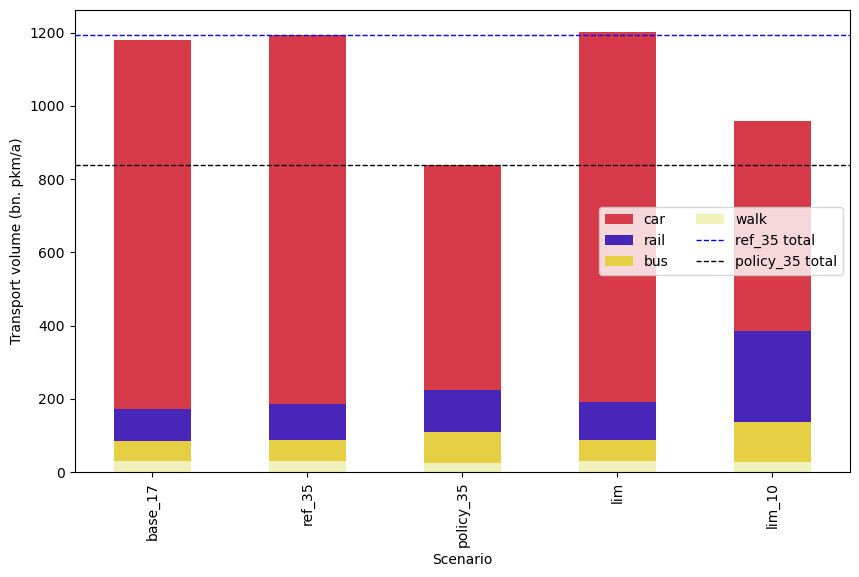

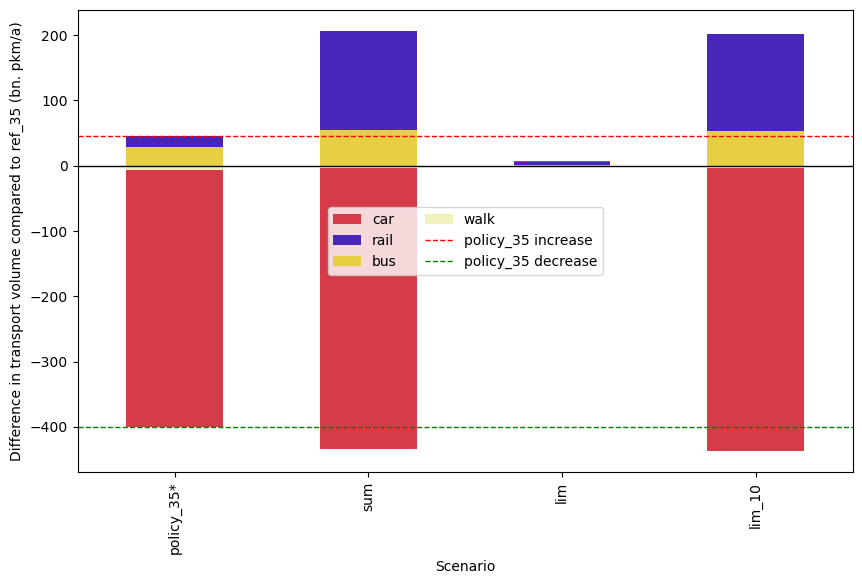

Explanations:
Total transport volume of reference scenario ref_35: 1194.1 bn. pkm/a
'*' := scenario was not included to calculate the sum of differences to ref_35


In [19]:
# Define the order of modes
mode_order = ['air', 'walk', 'bus', 'rail', 'car']

def pivot_excl_merged_pkm(excl_merged, mode_order):
    """Pivot the dataframe to convert modes into columns."""
    pivoted_df = excl_merged.pivot(index='scenario', columns='mode', values=unit)
    pivoted_df.fillna(value=0, inplace=True)

    # Reorder the columns based on mode_order
    pivoted_df = pivoted_df[mode_order]
    pivoted_df = pivoted_df.reindex(scenarios)
    pivoted_df.rename({"base": "base_17"}, axis='index', inplace=True)
    pivoted_df.drop(labels='air', axis='columns', inplace=True)
    
    return pivoted_df


def plot_abs_stacked_pkm(pivoted_df, scenarios):
    """Plot absolute values as stacked bar plot."""
    fig, ax = plt.subplots(figsize=(10, 6))
    pivoted_df.plot(kind='bar', stacked=True, ax=ax, color=colormap)

    # Add horizontal lines for "ref_35" and "policy_35"
    ref_35_sum = pivoted_df.loc["ref_35"].sum()
    policy_35_sum = pivoted_df.loc["policy_35"].sum()
    ax.axhline(y=ref_35_sum, color='blue', linestyle='--', linewidth=1)
    ax.axhline(y=policy_35_sum, color='black', linestyle='--', linewidth=1)
    
    # Add vertical lines
    vert_lines = [
        pivoted_df.index.get_loc("policy_35"),
        pivoted_df.index.get_loc("tax_12"),
        pivoted_df.index.get_loc("prk_4"),
        pivoted_df.index.get_loc("lim"),
        pivoted_df.index.get_loc("pt_9"),
        pivoted_df.index.get_loc("inf_6")
    ]
    
    for line_idx in vert_lines:
        ax.axvline(x=line_idx + 0.5, color='gray', linestyle='-', linewidth=1)

    # Add labels for "ref_35" and "policy_35" lines
    #ax.text(15.5, ref_35_sum, "ref_35", ha='right', va='bottom')
    #ax.text(16, policy_35_sum, "policy_35", ha='right', va='bottom')

    plt.xlabel('Scenario')
    plt.ylabel(f'Transport volume ({unit}/a)')
    
    # customize legend
    handles, labels = ax.get_legend_handles_labels()
    legend_handles = [Line2D([0], [0], color='black', linestyle='--', linewidth=1),
                      Line2D([0], [0], color='blue', linestyle='--', linewidth=1)] + handles
    legend_labels = ["policy_35 total", "ref_35 total"] + labels
    # reverse order of legend to keep order consistent
    plt.legend(reversed(legend_handles), reversed(legend_labels), loc='center right', ncol=2)
    plt.savefig(save_path + "pkm_stacked_absolute.pdf", bbox_inches='tight')
    plt.show()
    
    return None
                     

def plot_diff_stacked_pkm(pivoted_df, scenarios):
    """Plot DIFFERENCE to ref_35 as stacked bar plot."""
    # To calculate sum of differences to ref_35 to be compared with policy_35
    # make a list with only scenarios part of the "policy_35"-scenario
    # deductions of local pt price, but pt_6 makes local pt free
    scen_not_in_policy_35 = ["base", "ref_35", "policy_35", 
                             "ref_35_old", "com_7", "com_0", "policy_35_old",
                             "pt_1", "pt_2-4", "pt_5", "pt_7"]
    scen_in_policy_35 = [scen for scen in scenarios if scen not in scen_not_in_policy_35]
    
    def calculate_diff(pivoted_df, scenarios, scen_in_policy_35):
        # leave out base and ref_35 scenario
        pivoted_df.drop(labels="base_17", axis='index', inplace=True)

        # Calculate difference to ref_35
        df_diff = pivoted_df.subtract(pivoted_df.loc['ref_35'])

        # Filter the DataFrame based on the scenarios in scen_in_policy_35
        filtered_df = df_diff.loc[scen_in_policy_35]

        # Add a new row "sum_diff" that contains the sum of the values for each column
        sum_row = pd.DataFrame(filtered_df.sum(axis=0), columns=['sum']).T

        # Find the index position of "policy_35"
        policy_35_index = df_diff.index.get_loc("policy_35")

        # Create a new DataFrame with two parts:
        # Part 1: Rows before "policy_35"
        # Part 2: The new row "sum_diff"
        # Part 3: Rows after "policy_35"
        df_diff = pd.concat([df_diff.iloc[:policy_35_index + 1], sum_row, df_diff.iloc[policy_35_index + 1:]])

        # Drop ref_35 scenario as its not relevant for the "difference to ref_35"
        df_diff.drop(labels='ref_35', axis='index', inplace=True)
        
        return df_diff
    
    
    # Call inner function
    df_diff = calculate_diff(pivoted_df, scenarios, scen_in_policy_35)

    fig, ax = plt.subplots(figsize=(10, 6))
    df_diff.plot(kind='bar', stacked=True, ax=ax, color=colormap)

    # Insert lines at y = 0 and the lowest/highest bar ends for "policy_35"
    ax.axhline(y=0, color='black', linewidth=1)  # Line at y = 0

    # Find the minimum and maximum y-positions of the "policy_35" bars
    policy_35_row = df_diff.loc["policy_35"]
    min_y = policy_35_row[policy_35_row < 0].sum()
    max_y = policy_35_row[policy_35_row > 0].sum()

    # Line at the lowest bar end for "policy_35"
    ax.axhline(y=min_y, color='green', linestyle='--', linewidth=1)

    # Line at the highest bar end for "policy_35"
    ax.axhline(y=max_y, color='red', linestyle='--', linewidth=1)
    
    # Add vertical lines
    vert_lines = [
        pivoted_df.index.get_loc("policy_35"),
        pivoted_df.index.get_loc("tax_12"),
        pivoted_df.index.get_loc("prk_4"),
        pivoted_df.index.get_loc("lim"),
        pivoted_df.index.get_loc("pt_9"),
        pivoted_df.index.get_loc("inf_6")
    ]
    
    for line_idx in vert_lines:
        ax.axvline(x=line_idx + 0.5, color='gray', linestyle='-', linewidth=1)
    
    plt.xlabel('Scenario')
    plt.ylabel(f'Difference in transport volume compared to ref_35 ({unit}/a)')

    # Update the x-axis labels and add a "*" behind all scenarios not in "sum_diff"
    plt.xticks(range(len(df_diff.index)), [custom_xticklabels(label, scen_in_policy_35) for label in df_diff.index])

    # customize legend
    handles, labels = ax.get_legend_handles_labels()
    legend_handles = [Line2D([0], [0], color='green', linestyle='--', linewidth=1),
                      Line2D([0], [0], color='red', linestyle='--', linewidth=1)] + handles
    legend_labels = ["policy_35 decrease", "policy_35 increase"] + labels
    # reverse order of legend to keep order consistent
    plt.legend(reversed(legend_handles), reversed(legend_labels), loc='center', ncol=2)
    plt.savefig(save_path + "pkm_stacked_diff_ref_35_abs.pdf", bbox_inches='tight')
    
    plt.show()
    
    # Print explanations
    sum_ref_35 = pivoted_df.loc['ref_35'].sum()
    sum_ref_35 = round(sum_ref_35, 1)
    print(f"Explanations:")
    print(f"Total transport volume of reference scenario ref_35: {sum_ref_35} {unit}/a")
    print("'*' := scenario was not included to calculate the sum of differences to ref_35")
    return None

pivoted_df = pivot_excl_merged_pkm(excl_merged, mode_order)
plot_abs_stacked_pkm(pivoted_df, scenarios)
plot_diff_stacked_pkm(pivoted_df, scenarios)

## Compare (local and long-distance) emissions for different scenarios

In [ ]:
# define output excel file to be read for every scenario (every folder in 'output')
# and define other variables to be called by the functions
output_path = '../output/'
save_path = '../output/comparison/emiss/'
file_name = 'results_total.xlsx'
sheet_name__local = 'emissions_local'
sheet_name_long = 'emissions_long'
modes_local = ['bus', 'car', 'rail_short', 'walk']
modes_long = ['air', 'bus', 'coach', 'rail_long', 'rail_short', 'car_long']
unit = 'mio tCO2eq'

if not os.path.exists(save_path):
    os.mkdirs(save_path)


def create_excl_merged_emiss(output_path, file_name, sheet_name, unit, 
                       modes_local, modes_long, scenarios):
    """Create a DataFrame with the emissions data from all scenario outputs."""
    
    # create a list with all paths to the files to be compared
    file_list = []
    for x in range(len(scenarios)):
        file_list.append(os.path.join(output_path, scenarios[x], file_name))

    def get_local_emiss(file_list, sheet_name, scenarios, modes_local):
        """Retrieve LOCAL emissions."""
        # read the data for every scenario and combine it in one list
        excl_list_local = []
        for x in range(len(file_list)):
            excl_list_local.append(pd.read_excel(file_list[x], sheet_name=sheet_name__local))

        # convert the list to a pandas DataFrame for better handling
        excl_merged_local = pd.DataFrame()
        for excl_file in excl_list_local:
            excl_merged_local = pd.concat([excl_merged_local, excl_file], ignore_index=True)

        excl_merged_local.rename({'route_type':'mode'}, axis=1, inplace=True)
        to_replace = {'bus': 'bus_local', 'rail_short': 'rail_local', 'car': 'car_local'}
        excl_merged_local['mode'].replace(to_replace, inplace=True)

        # Add scenario names to pandas dataframes
        excl_merged_local['scenario'] = ""
        for x in range(len(scenarios)):
            # write the name in the scenario to all respective modes
            for y in range(0, len(modes_local)):
                excl_merged_local.at[y+x*len(modes_local), 'scenario'] = scenarios[x]
                
        return excl_merged_local


    def get_long_dist_emiss(file_list, sheet_name, scenarios, modes_long):
        """Retrieve LONG distance emissions."""
        # Read in the data for every scenario as list
        excl_list_long = []
        for x in range(len(file_list)):
            excl_list_long.append(pd.read_excel(file_list[x], sheet_name=sheet_name_long))

        # Convert the list to a pandas DataFrame for better handling
        excl_merged_long = pd.DataFrame()
        for excl_file in excl_list_long:
            excl_merged_long = pd.concat([excl_merged_long, excl_file], ignore_index=True)

        excl_merged_long.rename({'Unnamed: 0':'mode'}, axis=1, inplace=True)
        excl_merged_long['mode'].replace({'bus': 'bus_long'}, inplace=True)

        excl_merged_long['scenario'] = ""
        for x in range(len(scenarios)):

            # add a row for 'air' if that row is missing (= no air travel)
            if excl_merged_long.at[x*len(modes_long), 'mode'] != 'air':
                excl_merged_long.loc[x*len(modes_long)-0.5] = [0.0, 'air', np.nan]
                excl_merged_long = excl_merged_long.sort_index().reset_index(drop=True)
    
            # write the name in the scenario to all respective modes
            for y in range(0, len(modes_long)):
                excl_merged_long.at[y+x*len(modes_long), 'scenario'] = scenarios[x]
        
        return excl_merged_long
    
    
    # Call the inner functions
    excl_merged_local = get_local_emiss(file_list, sheet_name, scenarios, modes_local)
    excl_merged_long = get_long_dist_emiss(file_list, sheet_name, scenarios, modes_long)
        
    # Combine the dataframes
    excl_merged = pd.concat([excl_merged_local, excl_merged_long], ignore_index=True)
    excl_merged = swap_columns(excl_merged, unit, 'scenario')
    excl_merged = swap_columns(excl_merged, 'mode', 'scenario')
    
    return excl_merged

        
# Call outer function
excl_merged = create_excl_merged_emiss(output_path, file_name, sheet_name, unit, 
                                       modes_local, modes_long, scenarios)

#print(excl_merged.tail(50))

In [ ]:
modes = ['bus_local', 'car_local', 'rail_local',
         'air', 'bus_long', 'coach', 'rail_short', 'rail_long', 'car_long'] # walk left out


def plot_abs_emiss(modes, excl_merged):
    """Plot abosulte emissions independently for every mode with all scenarios in each plot."""
    excl_merged.fillna(value=0, inplace=True)
    for idx, mode in enumerate(modes):
        df = excl_merged.loc[excl_merged['mode'] == mode]
        df = df.drop(columns = ["mode"]).reset_index(drop=True)

        # plot absolute data in separate bar charts
        # create bar chart
        fig = plt.figure(figsize=(10,5))
        plt.bar(df['scenario'], df[unit], width =0.7)
        plt.xticks(rotation=90)
        plt.xlabel('Scenario')
        plt.ylabel(f'Emissions of {mode} ({unit})')
        plt.savefig(save_path + "emiss_" f"{mode}_absolute.pdf", bbox_inches='tight')
        plt.close(fig)
        
    return None

        
# Call the function for all modes
plot_abs_emiss(modes, excl_merged)

In [ ]:
# Define the order of modes
modes = ['car_long', 'car_local', 
         'bus_long', 'coach', 'bus_local',
         'rail_short', 'rail_local', 'rail_long', 
         'air'] # walk left out
mode_order = modes[::-1] # reversed order

def pivot_df_emiss(excl_merged, scenarios, mode_order):
    excl_merged.fillna(value=0, inplace=True)

    # Pivot the dataframe to convert modes into columns
    pivoted_df = excl_merged.pivot(index='scenario', columns='mode', values=unit)
    pivoted_df.fillna(value=0, inplace=True)

    # Reorder the columns based on mode_order
    pivoted_df = pivoted_df[mode_order]
    pivoted_df = pivoted_df.reindex(scenarios)
    pivoted_df.rename({"base": "base_17"}, axis='index', inplace=True)
    pivoted_df.drop(labels='air', axis='columns', inplace=True)
    
    return pivoted_df


def plot_abs_stacked_emiss(pivoted_df, scenarios, save_path, mode_order):
    """Plot ABSOLUTE values as stacked bar plot with all modes and scenarios in one plot."""
    fig = pivoted_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=colormap)
    
    # Add horizontal lines for "ref_35" and "policy_35"
    ref_35_sum = pivoted_df.loc["ref_35"].sum()
    policy_35_sum = pivoted_df.loc["policy_35"].sum()
    center_x = len(pivoted_df.index) / 2
    fig.axhline(y=ref_35_sum, color='blue', linestyle='--', linewidth=1)
    fig.axhline(y=policy_35_sum, color='black', linestyle='--', linewidth=1)
    
    # Add vertical lines
    vert_lines = [
        pivoted_df.index.get_loc("policy_35"),
        pivoted_df.index.get_loc("tax_12"),
        pivoted_df.index.get_loc("prk_4"),
        pivoted_df.index.get_loc("lim"),
        pivoted_df.index.get_loc("pt_9"),
        pivoted_df.index.get_loc("inf_6")
    ]
    
    for line_idx in vert_lines:
        fig.axvline(x=line_idx + 0.5, color='gray', linestyle='-', linewidth=1)
    
    # Add labels for "ref_35" and "policy_35" lines
    #fig.text(center_x, ref_35_sum, "ref_35", ha='center', va='bottom')
    #fig.text(center_x, policy_35_sum, "policy_35", ha='center', va='bottom',
             #bbox=dict(facecolor='white', alpha=0.6))  # Set alpha (transparency) as needed)
    
    plt.xlabel('Scenario')
    plt.ylabel(r'Emissions (Mt CO$_2$eq/a)')
    
    # customize legend
    handles, labels = fig.get_legend_handles_labels()
    legend_handles = [Line2D([0], [0], color='black', linestyle='--', linewidth=1),
                      Line2D([0], [0], color='blue', linestyle='--', linewidth=1)] + handles
    legend_labels = ["policy_35 emiss", "ref_35 emiss"] + labels

    # reverse order of legend to keep order consistent
    plt.legend(reversed(legend_handles), reversed(legend_labels), loc='upper right', ncol=2)
    #plt.close(fig)
    plt.savefig(save_path + "emiss_stacked_absolute.pdf", bbox_inches='tight')
    
    return None


def plot_diff_stacked_emiss(pivoted_df, scenarios, save_path, mode_order):
    # To calculate sum of differences to ref_35 to be compared with policy_35
    # make a list with only scenarios part of the "policy_35"-scenario
    # deductions of local pt price, but pt_6 makes local pt free
    scen_not_in_policy_35 = ["base", "ref_35", "policy_35", 
                             "ref_35_old", "policy_35_old", "com_0", "com_7",
                             "pt_1", "pt_2-4", "pt_5", "pt_7"]
    scen_in_policy_35 = [scen for scen in scenarios if scen not in scen_not_in_policy_35]
    
    def calculate_diff_ref_emiss(pivoted_df, scenarios):
        pivoted_df.drop(labels='base_17', axis='index', inplace=True)
        
        # Calculate difference to ref_35
        df_diff = pivoted_df.subtract(pivoted_df.loc['ref_35'])

        # Filter the DataFrame based on the scenarios in scen_in_policy_35
        filtered_df = df_diff.loc[scen_in_policy_35]

        # Add a new row "sum_diff" that contains the sum of the values for each column
        sum_row = pd.DataFrame(filtered_df.sum(axis=0), columns=['sum']).T

        # Find the index position of "policy_35"
        policy_35_index = df_diff.index.get_loc("policy_35")

        # Create a new DataFrame with two parts:
        # Part 1: Rows before "policy_35"
        # Part 2: The new row "sum_diff"
        # Part 3: Rows after "policy_35"
        df_diff = pd.concat([df_diff.iloc[:policy_35_index + 1], sum_row, df_diff.iloc[policy_35_index + 1:]])

        # Drop ref_35 and base scenario as its not relevant for the "difference to ref_35"
        df_diff.drop(labels='ref_35', axis='index', inplace=True)
        
        return df_diff
    
    
    # Call inner function
    df_diff = calculate_diff_ref_emiss(pivoted_df, scenarios)

    # Plot stacked bar chart
    fig = df_diff.plot(kind='bar', stacked=True, figsize=(10, 6), color=colormap)
    
    # Insert lines at y = 0 and the lowest/highest bar ends for "policy_35"
    fig.axhline(y=0, color='black', linewidth=1)  # Line at y = 0

    # Find the minimum and maximum y-positions of the "policy_35" bars
    policy_35_row = df_diff.loc["policy_35"]
    min_y = policy_35_row[policy_35_row < 0].sum()
    max_y = policy_35_row[policy_35_row > 0].sum()
    center_x = len(df_diff.index) / 2
    
    # Line at the highest bar end for "policy_35"
    fig.axhline(y=max_y, color='red', linestyle='--', linewidth=1)
    #fig.text(center_x, max_y, "policy_35 increase", ha='center', va='bottom')

    # Line at the lowest bar end for "policy_35"
    fig.axhline(y=min_y, color='green', linestyle='--', linewidth=1)
    #fig.text(center_x, min_y, "policy_35 decrease", ha='center', va='bottom')
    
    # Add vertical lines
    vert_lines = [
        pivoted_df.index.get_loc("policy_35"),
        pivoted_df.index.get_loc("tax_12"),
        pivoted_df.index.get_loc("prk_4"),
        pivoted_df.index.get_loc("lim"),
        pivoted_df.index.get_loc("pt_9"),
        pivoted_df.index.get_loc("inf_6")
    ]
    
    for line_idx in vert_lines:
        fig.axvline(x=line_idx + 0.5, color='gray', linestyle='-', linewidth=1)
    
    plt.xlabel('Scenario')
    plt.ylabel(r'Difference in emissions compared to ref_35 (Mt CO$_2$eq/a)')

    # Update the x-axis labels and add a "*" behind all scenarios not in "sum_diff"
    plt.xticks(range(len(df_diff.index)), 
               [custom_xticklabels(label, scen_in_policy_35) for label in df_diff.index])

    # customize legend
    handles, labels = fig.get_legend_handles_labels()
    legend_handles = [Line2D([0], [0], color='green', linestyle='--', linewidth=1),
                      Line2D([0], [0], color='red', linestyle='--', linewidth=1)] + handles
    legend_labels = ["policy_35 decrease", "policy_35 increase"] + labels

    # reverse order of legend to keep order consistent
    plt.legend(reversed(legend_handles), reversed(legend_labels), loc='center')
    plt.savefig(save_path + "emiss_stacked_diff_ref_35_tCO2.pdf", bbox_inches='tight')
    plt.show()
    
    # Print explanations
    sum_ref_35 = pivoted_df.loc['ref_35'].sum()
    sum_ref_35 = round(sum_ref_35, 1)
    print(f"Explanations:")
    print(f"Total emissions of reference scenario ref_35: {sum_ref_35} {unit}")
    print("'*' := scenario was not included to calculate the sum of differences to ref_35")
    
    return None


# Call the functions
pivoted_df = pivot_df_emiss(excl_merged, scenarios, mode_order)
plot_abs_stacked_emiss(pivoted_df, scenarios, save_path, mode_order)
plot_diff_stacked_emiss(pivoted_df, scenarios, save_path, mode_order)

## Analyse carownership outputs

In [ ]:
output_path = '../car_ownership/co_results/'
save_path = '../output/comparison/car_ownership/'
sheet_name = 'results'
#unit = 'bn. pkm'
#modes = ['air', 'bus', 'car', 'rail', 'walk', 'total']

if not os.path.exists(save_path):
    os.mkdirs(save_path)

# exclude old scenarios, as we have no results saved from them:
scen_old = ["ref_35_old", "com_7", "com_0", "policy_35_old"]
scenarios = [scen for scen in scenarios if scen not in scen_old]


def collect_outputs(output_path, sheet_name):

    # create a list with all paths to the files to be compared
    file_list = []
    for x in range(len(scenarios)):
        file_name = f"{scenarios[x]}.xlsx"
        file_list.append(os.path.join(output_path, file_name))

    # read the data for every scenario and combine it in one list
    excl_list = []
    for x in range(len(file_list)):
        excl_list.append(pd.read_excel(file_list[x], sheet_name=sheet_name))

    # convert the list to a pandas DataFrame for better handling
    excl_merged = pd.DataFrame()
    for excl_file in excl_list:
        excl_merged = pd.concat([excl_merged, excl_file], ignore_index=True)

    # add the scenario name to the data in the pandas DataFrame
    excl_merged['scenario'] = ""
    for x in range(len(scenarios)):
        # write the name of the scenario to every table
        for y in range(0, 26):
            excl_merged.at[y+x*25, 'scenario'] = scenarios[x]
    
    return excl_merged
    
excl_merged = collect_outputs(output_path, sheet_name)

In [ ]:
# plot the data, for every urbanisation type with values for all scenarios in it

# Function to plot scatter plots
def plot_scatter(df, var, plot_type, save_name):
    """Plot scatter plots.
    
    If "percent" is selected as plot_type, the difference in percent
    to ref_35 is plotted.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = {'rural': 'blue', 'suburban': 'green', 'urban': 'red'}
    
    ax.set_xlabel('Scenario')

    if plot_type == 'absolute':
        
        if var == "Cars per household modelled":
            ax.set_ylabel('Number of cars per household')
        else:
            ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0, symbol=None))
            ax.set_ylabel("Share of households with access to a car [%]")
        
        # Add horizontal bars for each urbanization type at y = policy_35 values
        ref_35_row = df[df['scenario'] == 'ref_35'].iloc[0]
        ax.axhline(y=ref_35_row['rural'], color=colors['rural'], linestyle='--', linewidth=1)
        ax.axhline(y=ref_35_row['suburban'], color=colors['suburban'], linestyle='--', linewidth=1)
        ax.axhline(y=ref_35_row['urban'], color=colors['urban'], linestyle='--', linewidth=1)
        
        save_suffix = "_absolute.pdf"

    elif plot_type == 'percent':
        df = df.drop(df[df['scenario'] == 'base_17'].index)
        
        ref_35_row = df[df['scenario'] == 'ref_35'].iloc[0]
        df['rural'] = ((df['rural'] - ref_35_row['rural']) / ref_35_row['rural']) * 100
        df['suburban'] = ((df['suburban'] - ref_35_row['suburban']) / ref_35_row['suburban']) * 100
        df['urban'] = ((df['urban'] - ref_35_row['urban']) / ref_35_row['urban']) * 100
        
        # Add horizontal bars for each urbanization type at y = policy_35 values
        policy_35_row = df[df['scenario'] == 'policy_35'].iloc[0]
        ax.axhline(y=policy_35_row['rural'], color=colors['rural'], linestyle='--', linewidth=1)
        ax.axhline(y=policy_35_row['suburban'], color=colors['suburban'], linestyle='--', linewidth=1)
        ax.axhline(y=policy_35_row['urban'], color=colors['urban'], linestyle='--', linewidth=1)
        
        df = df.drop(df[df['scenario'] == 'ref_35'].index)
        
        # Add a horizontal bar at y=0
        ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax.set_ylabel(f'Difference in {var} compared to ref_35 [%]')
        
        save_suffix = "_percent_change.pdf"
    else:
        print("Error. Select 'absolute' or 'percent' as plot_type!")
        return

    # Add vertical lines
    vert_lines = [
        pivoted_df.index.get_loc("policy_35"),
        pivoted_df.index.get_loc("tax_12"),
        pivoted_df.index.get_loc("prk_4"),
        pivoted_df.index.get_loc("lim"),
        pivoted_df.index.get_loc("pt_9"),
        pivoted_df.index.get_loc("inf_6")
    ]
    
    for line_idx in vert_lines:
        ax.axvline(x=line_idx + 1.5, color='gray', linestyle='-', linewidth=1)
    
    x = df['scenario']
    y_rural = df['rural']
    y_suburban = df['suburban']
    y_urban = df['urban']
    
    # Color all spots for scenarios in gray
    ax.scatter(x, y_rural, label='No change', color='gray', marker='^')
    ax.scatter(x, y_suburban, label='_nolegend_', color='gray', marker='^')
    ax.scatter(x, y_urban, label='_nolegend_', color='gray', marker='^')

    # Highlight the scenarios of interest in their respective colors
    scen_changed = ['base_17', 'ref_35', 'policy_35', 'inf_1', 'inf_2', 'reg_4']
    mask = df['scenario'].isin(scen_changed)
    ax.scatter(x[mask], y_rural[mask], label=f'Rural', color=colors['rural'], marker='^')
    ax.scatter(x[mask], y_suburban[mask], label=f'Suburban', color=colors['suburban'], marker='^')
    ax.scatter(x[mask], y_urban[mask], label=f'Urban', color=colors['urban'], marker='^')
    
    # customize legend
    handles, labels = ax.get_legend_handles_labels()
    legend_handles = handles + [Line2D([0], [0], color=colors['rural'], linestyle='--', linewidth=1),
                                Line2D([0], [0], color=colors['suburban'], linestyle='--', linewidth=1),
                                Line2D([0], [0], color=colors['urban'], linestyle='--', linewidth=1)]
    if plot_type == 'absolute':
        legend_labels = labels + ["ref_35 rural", "ref_35 suburban", "ref_35 urban"]
    else:    
        legend_labels = labels + ["policy_35 rural", "policy_35 suburban", "policy_35 urban"]
    
    if var == "Cars per household modelled":
        plt.legend(legend_handles, legend_labels, loc='lower right', ncol=2)
    else:  # var == "Car availability modelled" and plot_type == "absolute":
        plt.legend(legend_handles, legend_labels, loc='lower right', ncol=2)
    
    plt.xticks(rotation=90)
    plt.tight_layout()
    #plt.close()
    fig.savefig(save_path + save_name + save_suffix)
    
    return None


def plot_bar_separate(df, idx, var, urb):
    """Plot separate bar charts for every urbanization type."""
    cars = df[['scenario', urb]]
    # create bar chart
    fig = plt.figure(figsize=(10,5))
    plt.bar(cars['scenario'], cars[urb], width=0.7)
    plt.xticks(rotation=90)
    plt.xlabel('Scenario')
    plt.ylabel(f'{var} {urb}')
    plt.savefig(save_path + save_name[idx] + "_" + urb + ".pdf", bbox_inches='tight')
    plt.close(fig)
    
    return None
    


# Plot scatter plots for each variable in to_analyse
to_analyse = ["Cars per household modelled", "Car availability modelled"]
save_name = ["car_p_hh", "car_avail"]
excl_merged.fillna(value=0, inplace=True)
excl_merged['scenario'] = excl_merged['scenario'].replace('base', 'base_17')


for idx, var in enumerate(to_analyse):
    df = excl_merged.loc[excl_merged['key'] == var]
    df = swap_columns(df, "key", "scenario")
    df = df.drop(columns = ["choice", "key"]).reset_index(drop=True)
    
    # plot absolute data in separate bar charts
    for urb in ["rural", "suburban", "urban"]:
        plot_bar_separate(df, idx, var, urb)
    
    # Plot absolute values together as scatter plot
    plot_scatter(df.copy(), var, 'absolute', save_name[idx])

    # Plot percent differences compared to ref_35 together as scatter plot
    plot_scatter(df.copy(), var, 'percent', save_name[idx])